# Home 3: Build a CNN for image recognition.

### Name: Prathamesh Dilip Bane (CWID 10457749)


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/HM3/HM3.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [2]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170500096/170498071 [==============================] - 3s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
    
from tensorflow.keras.utils import to_categorical    
y_train_vec = to_categorical(y_train, num_classes=10)
y_test_vec = to_categorical(y_test, num_classes=10)    
#If we need to convert our dataset into categorical format (and hence one-hot encoded format),
# we can do so using Scikit-learn’s OneHotEncoder module. However, TensorFlow also offers its own implementation: tensorflow.keras.utils.to_categorical.
# It’s a utility function which allows us to convert integer targets into categorical and hence one-hot encoded ones.

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:

def to_one_hot(y, num_class=10):
    return to_categorical(y)



y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [5]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [7]:
from keras import optimizers

learning_rate = 3E-4 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [8]:
history = model.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 43s 8ms/step - loss: 1.7156 - acc: 0.4010 - val_loss: 1.4091 - val_acc: 0.5503
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0196 - acc: 0.6381 - val_loss: 0.9135 - val_acc: 0.6756
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7782 - acc: 0.7305 - val_loss: 0.8423 - val_acc: 0.7124
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6376 - acc: 0.7798 - val_loss: 0.7366 - val_acc: 0.7471
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.5456 - acc: 0.8145 - val_loss: 0.7294 - val_acc: 0.7539
Epoch 6/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4726 - acc: 0.8368 - val_loss: 0.6791 - val_acc: 0.7717
Epoch 7/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4008 - acc: 0.8631 - val_loss: 0.6385 - val_acc: 0.7868
Epoch 8/10
1250/1250 [==============================] - 9s 7m

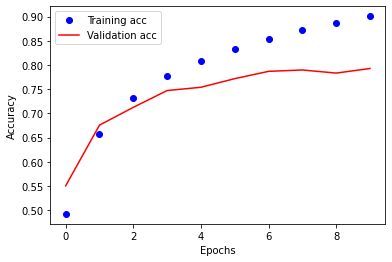

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [ ]:
<Compile your model again (using the same hyper-parameters)>
...

In [ ]:

<Train your model on the entire training set (50K samples)>
<Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
<Do NOT use the validation_data option (because now you do not have validation data)>
...

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:50000]


x_train = x_train[train_indices, :]
y_train_vec = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train_vec.shape))




Shape of x_tr: (50000, 32, 32, 3)
Shape of y_tr: (50000, 10)


In [11]:
from keras import optimizers

learning_rate = 1E-5 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])



In [12]:
history = model.fit(x_train, y_train_vec, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 13s 7ms/step - loss: 0.3040 - acc: 0.9034
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2683 - acc: 0.9151
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2578 - acc: 0.9222
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2437 - acc: 0.9259
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2396 - acc: 0.9271
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2280 - acc: 0.9310
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2209 - acc: 0.9328
Epoch 8/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2143 - acc: 0.9329
Epoch 9/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2109 - acc: 0.9360
Epoch 10/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2061 - acc: 0.9371


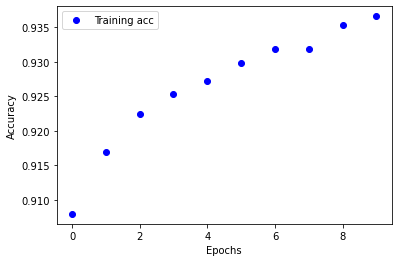

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.5971 - acc: 0.8199
loss = 0.5970531702041626
accuracy = 0.8198999762535095
